In [33]:
# ========================================
# 1. Importações e Setup Geral
# ========================================

In [34]:
import itertools
import json
import os
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.datasets import get_rdataset
from statsmodels.tsa.arima.model import ARIMA

# Ignorar avisos para uma saída mais limpa
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [35]:
# =========================================================
# 2. Setup de Reprodutibilidade
# =========================================================

In [36]:
# Definimos uma "semente" para garantir que, se houver algum processo
# aleatório no futuro (comum em modelos neurais), os resultados sejam os mesmos.
# Para o ARIMA padrão do statsmodels, o processo já é determinístico,
# mas esta é uma excelente prática de programação.
def definir_seed(seed_value=42):
    """Define a semente para reprodutibilidade."""
    np.random.seed(seed_value)
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    print(f"Semente de reprodutibilidade definida como: {seed_value}")


definir_seed(42)

Semente de reprodutibilidade definida como: 42


In [37]:
# =======================================
# 3. Funções de Carregamento e Divisão de Dados
# ========================================

In [38]:
def salvar_dataset_local(serie, dataset_name):
    """
    Apenas salva uma série temporal em um arquivo CSV local.
    """
    dir_path = "./datasets"
    os.makedirs(dir_path, exist_ok=True)
    file_path = os.path.join(dir_path, f"{dataset_name.lower()}.csv")
    df = pd.DataFrame({"date": serie.index, "value": serie.values})
    df.to_csv(file_path, index=False)
    print(f"-> Cópia do dataset '{dataset_name}' salva em: {file_path}")


def carregar_serie(nome):
    """
    Sempre busca a série do statsmodels e salva uma cópia local.
    """
    print(f"Buscando dados de '{nome}' via statsmodels...")
    nome_base = nome.lower()

    if nome_base == "airpassengers":
        df = get_rdataset("AirPassengers", package="datasets").data
        serie = pd.Series(df['value'].values, index=pd.date_range(start="1949-01-01", periods=len(df), freq="MS"),
                          name="AirPassengers")
    elif nome_base == "lynx":
        df = get_rdataset("lynx", package="datasets").data
        serie = pd.Series(df['value'].values, index=pd.date_range(start="1821", periods=len(df), freq="A"), name="Lynx")
    elif nome_base == "co2":
        df = get_rdataset("CO2", package="datasets").data
        df = df.ffill()
        serie = pd.Series(df['value'].values, index=pd.date_range(start="1958-03-29", periods=len(df), freq="MS"),
                          name="CO2")
    elif nome_base == "sunspots":
        df = get_rdataset("sunspots", package="datasets").data
        serie = pd.Series(df['value'].values, index=pd.date_range(start="1749-01-01", periods=len(df), freq="MS"),
                          name="Sunspots")
    elif nome_base == "austres":
        df = get_rdataset("austres", package="datasets").data
        serie = pd.Series(df['value'].values, index=pd.date_range(start="1971-03-01", periods=len(df), freq="QS-MAR"),
                          name="AustralianResidents")
    elif nome_base == "nottem":
        df = get_rdataset("nottem", package="datasets").data
        serie = pd.Series(df['value'].values, index=pd.date_range(start="1920-01-01", periods=len(df), freq="MS"),
                          name="Nottingham")
    else:
        raise ValueError(f"Série '{nome}' não reconhecida.")

    salvar_dataset_local(serie, nome)
    return serie

In [39]:
def dividir_serie_temporal(serie, percentual_treino=0.7, percentual_validacao=0.15):
    """Divide a série em treino, validação e teste."""
    # ... (a função que já tínhamos)
    tamanho_total = len(serie)
    ponto_corte_treino = int(tamanho_total * percentual_treino)
    ponto_corte_validacao = int(tamanho_total * (percentual_treino + percentual_validacao))
    treino = serie.iloc[:ponto_corte_treino]
    validacao = serie.iloc[ponto_corte_treino:ponto_corte_validacao]
    teste = serie.iloc[ponto_corte_validacao:]
    return treino, validacao, teste

In [40]:
# =========================================================
# 4. Novas Funções para Otimização do ARIMA
# =========================================================

In [41]:
def encontrar_melhor_ordem_arima(serie_treino, p_range, d_range, q_range):
    """
    Testa várias combinações de (p, d, q) e retorna a melhor ordem e um DataFrame com os resultados.
    """
    print("Iniciando a busca pela melhor ordem ARIMA (Grid Search)...")
    melhor_aic = float('inf')
    melhor_ordem = None
    resultados = []

    combinacoes = list(itertools.product(p_range, d_range, q_range))
    print(f"Testando {len(combinacoes)} combinações...")

    for ordem in combinacoes:
        try:
            modelo = ARIMA(serie_treino, order=ordem)
            model_fit = modelo.fit()
            if model_fit.aic < melhor_aic:
                melhor_aic = model_fit.aic
                melhor_ordem = ordem
            resultados.append({'ordem': ordem, 'AIC': model_fit.aic, 'BIC': model_fit.bic})
        except:
            continue

    print("\nBusca concluída.")
    if melhor_ordem:
        print(f"Melhor Ordem encontrada: {melhor_ordem} com AIC: {melhor_aic:.2f}")
    else:
        print("Nenhuma combinação ARIMA válida foi encontrada.")

    return melhor_ordem, pd.DataFrame(resultados)


def exibir_resultados_grid_search(df_resultados):
    """
    Exibe a tabela de resultados do grid search, destacando a melhor linha com fundo azul e texto branco.
    """
    if df_resultados.empty:
        print("Nenhum resultado para exibir.")
        return

    df_sorted = df_resultados.sort_values(by='AIC').reset_index(drop=True)
    idx_melhor_aic = df_sorted['AIC'].idxmin()

    # Define o estilo para a melhor linha (fundo azul, texto branco)
    def destacar_melhor(s):
        estilo_melhor = 'background-color: #4285F4; color: white;'
        return [estilo_melhor if s.name == idx_melhor_aic else '' for i in s]

    print("\n--- Tabela de Resultados do Grid Search ---")
    # Aplica o estilo e exibe o DataFrame
    display(df_sorted.style.apply(destacar_melhor, axis=1).format('{:.2f}', subset=['AIC', 'BIC']))

Buscando dados de 'AirPassengers' via statsmodels...
-> Cópia do dataset 'AirPassengers' salva em: ./datasets\airpassengers.csv
Iniciando a busca pela melhor ordem ARIMA (Grid Search)...
Testando 48 combinações...

Busca concluída.
Melhor Ordem encontrada: (3, 1, 3) com AIC: 874.85

--- Tabela de Resultados do Grid Search ---


,ordem,AIC,BIC
0,"(3, 1, 3)",874.85,893.01
1,"(3, 2, 3)",882.54,900.63
2,"(3, 1, 2)",894.18,909.75
3,"(1, 1, 2)",895.89,906.27
4,"(1, 2, 2)",896.36,906.70
5,"(2, 1, 1)",896.37,906.75
6,"(2, 1, 3)",896.40,911.97
7,"(2, 1, 2)",896.43,909.41
8,"(0, 2, 3)",897.02,907.36
9,"(1, 1, 3)",897.59,910.57



Usando a melhor ordem (3, 1, 3) para treinar o modelo final e prever.


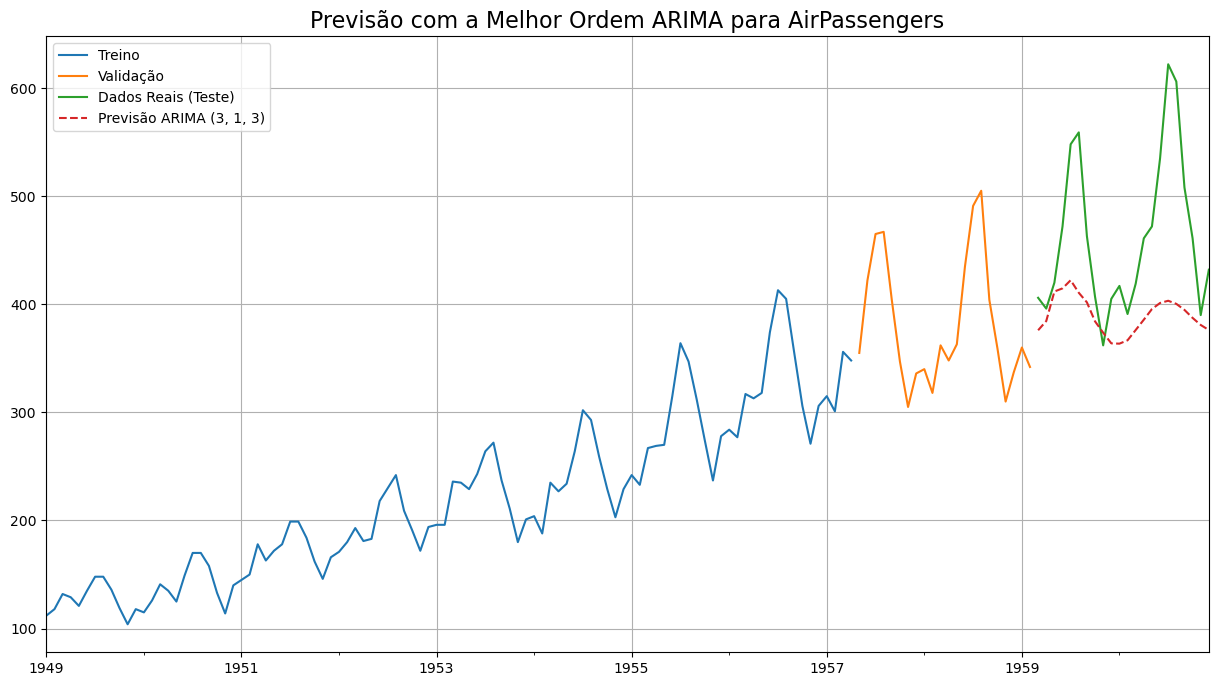

In [42]:
# =========================================================
# 5. Execução da Sessão de Otimização e Previsão
# =========================================================

# --- 5.1. Configurações da Sessão ---
NOME_DA_SERIE = "AirPassengers"
# Definimos os intervalos para p, d, q. 3x3x3 = 27 combinações.
p_vals = range(0, 4)  # p de 0 a 3
d_vals = range(0, 3)  # d de 0 a 2
q_vals = range(0, 4)  # q de 0 a 3

# --- 5.2. Preparação dos Dados ---
serie_completa = carregar_serie(NOME_DA_SERIE)
treino, validacao, teste = dividir_serie_temporal(serie_completa)
# A busca é feita nos dados de treino para evitar vazamento de dados
treino_com_freq = treino.asfreq(treino.index.freqstr)

# --- 5.3. Otimização: Carregar ou Encontrar a Melhor Ordem ---
melhor_ordem_arima, df_resultados = encontrar_melhor_ordem_arima(treino_com_freq, p_vals, d_vals, q_vals)

# --- 5.4. Exibição dos Resultados ---
# A nova função exibe a tabela formatada e destacada
exibir_resultados_grid_search(df_resultados)

# --- 5.5. Treinamento e Previsão com a Melhor Ordem ---
# Adicionamos uma verificação para o caso de nenhuma ordem ter sido encontrada
if melhor_ordem_arima:
    print(f"\nUsando a melhor ordem {melhor_ordem_arima} para treinar o modelo final e prever.")
    treino_validacao = pd.concat([treino, validacao]).asfreq('MS')
    modelo_final = ARIMA(treino_validacao, order=melhor_ordem_arima).fit()
    previsoes_teste = modelo_final.predict(start=teste.index[0], end=teste.index[-1])

    # Plotagem
    fig, ax = plt.subplots(figsize=(15, 8))
    treino.plot(ax=ax, label='Treino')
    validacao.plot(ax=ax, label='Validação')
    teste.plot(ax=ax, label='Dados Reais (Teste)')
    previsoes_teste.plot(ax=ax, label=f'Previsão ARIMA {melhor_ordem_arima}', linestyle='--')
    ax.set_title(f'Previsão com a Melhor Ordem ARIMA para {NOME_DA_SERIE}', fontsize=16)
    ax.legend()
    plt.grid(True)
    plt.show()
else:
    print("\nNão foi possível treinar o modelo final, pois nenhuma ordem válida foi encontrada.")